# workflow
* Understand & Modify md.py: We'll first adapt the provided code to use the correct parameters for Argon and to save the data we need (energies, coordinates, velocities).

* Simulate: Run the modified script to generate a trajectory file (.gro).

* Visualize (VMD): Use VMD to look at the simulation and make sure it seems physically reasonable.

* Analyze (Your Code): Write new Python functions to read the trajectory data and calculate the RDF and diffusion constant.


## Question 1&2 Setting up the Simulation

### 1.Caculation:
Reduced Temperature ($T^*$):
$ T^* = T / (\epsilon/k\_B) = 173 \text{ K} / 119.8 \text{ K} \approx 1.444$

mass of a single Argon atom:
m=0.03994 kg/mol/ (6.022*10^23 mol^-1)=6.633*10^-26 kg

density n:
n=1432 kg/m^3 /(6.633×10^−26 kg)≈2.159×10^28 atoms/m^3

$\rho^* = n \sigma^3 = (2.159 \times 10^{28} \text{ m}^{-3}) \times (3.405 \times 10^{-10} \text{ m})^3 \approx 0.851$

In [11]:
import numpy as np
from itertools import product
rho = 0.851 # old rho =0.6 reduced density of Argon in reduced units
dt = 0.004 # time step size
T_0 = 1.444 # old T_0 = 2 reduced temperature
N_cell = 3 # number of fcc unitcells in one direction
N = 4 * N_cell ** 3 # the total number of particles in the system
L_box = (N / rho) ** (1 / 3.0) # length of the whole simulation box
L_cell = L_box / N_cell # length of a unitcell
F = np.zeros((N, N, 3)) # matrix that contains all forces
ind = np.triu_indices(N, k=1) # indices of upper triangular matrix

In [12]:
#given functions
def IC_pos(N_cell, L_cell):
    '''
    use fcc structure to initilize positions
    '''
    pos = [[[x,  y, z], [x, 0.5 + y, 0.5 + z], [0.5 + x, y, 0.5 + z], [0.5 + x, 0.5 + y, z]] 
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    pos = np.array(pos).reshape((-1, 3))
    return pos * L_cell


def IC_vel(N):
    '''
    Maxwell-Boltzman distribution is a normal distribution
    '''
    vel = np.sqrt(T_0) * np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)
    return vel 


def find_force(pos, L_box=L_box):
    '''
    Minimum image convention. 
    '''
    r_vec = pos[ind[0]] - pos[ind[1]]
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box
    r_sq = np.sum(r_vec**2, axis=1)
    F_vec = -(48 / r_sq ** 7 - 24 / r_sq ** 4)[:, None] * r_vec
    F[ind[0], ind[1]] = F_vec
    pot = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)
    P = np.sum(F_vec * r_vec)
    return np.sum(F, axis=0) - np.sum(F, axis=1), pot, P

def time_step(pos, vel, F):
    vel += 0.5 * F * dt
    pos = pos + vel * dt
    pos_folded = np.mod(pos, L_box)
    #pos = np.mod(pos + vel * dt, L_box) # why both pos and pos_folded? 
    F, pot, P = find_force(pos_folded)
    vel += 0.5 * F * dt
    kin = 0.5 * np.sum(vel**2)
    return pos, vel, F, pot, kin, P


### 2.Proper time step and energy plot
???how to get reduced time
one reduced time unit is about 2.15 ps. We need to simulate for at least 12 ps/2.15 ps/unit≈5.58 reduced time units.

The provided time step is dt = 0.004 (in reduced units). This is a good, standard choice. In real units, this is 0.004×2.15 ps≈0.0086 ps or 8.6 fs, which is small enough to resolve atomic vibrations.
To simulate for 12 ps after equilibrium, let's set up the simulation loops. Let's say we equilibrate for 1000 steps and then run a "production" run for the required time.
Production time needed: 12 ps
Reduced time needed: 12/2.15≈5.58
Number of steps for production: 5.58/0.004≈1395 steps. Let's round up to 1500 steps for production and keep 1000 steps for equilibration.

In [ ]:
# modified function with new simulation loop, function still updating
def simulate():
    kins, pots, Ps = [], [], []
    pos = IC_pos(N_cell, L_cell)
    vel = IC_vel(N)
    F = find_force(pos)[0]
    for t in range(2500): # total 2500 steps
        pos, vel, F, pot, kin, P = time_step(pos, vel, F)
        if t >= 1000:  # production run starts after 1000 steps, production run for 1500 steps
            kins.append(kin)
            pots.append(pot)
            Ps.append(P)
        else: # equilibrium run
            vel *= np.sqrt(N * 3 * T_0 / (2 * kin)) # This is the thermostat
    return np.array(kins), np.array(pots), np.array(Ps)

In [15]:
# Plot Energies and Check for Stability 
# modified here with total energy tracking
def simulate():
    kins, pots, Ps, totals = [], [], [], []
    pos = IC_pos(N_cell, L_cell)
    vel = IC_vel(N)
    F = find_force(pos)[0]    
    for t in range(2500):# total 2500 steps
        pos, vel, F, pot, kin, P = time_step(pos, vel, F)
        if t >= 1000: # equilibrium run for first 1000 steps, then production run for next 1500 steps
            kins.append(kin)
            pots.append(pot)
            totals.append(kin + pot) # Store total energy
            Ps.append(P)
        else: # thermostat is on
                vel *= np.sqrt(N * 3 * T_0 / (2 * kin)) # This is the thermostat
    return np.array(kins), np.array(pots), np.array(totals), np.array(Ps)

In [ ]:
def simulate():
    kins, pots, Ps, totals = [], [], [], []
    pos = IC_pos(N_cell, L_cell)
    vel = IC_vel(N)
    F = find_force(pos)[0]   
    # The main loop
    for t in range(2500): # e.g., 1000 for equil., 1500 for prod.
        pos, vel, F, pot, kin, P = time_step(pos, vel, F)
        
        if t >= 1000:  # Start collecting after equilibrium
            kins.append(kin)
            pots.append(pot)
            totals.append(kin + pot)
            # Store the time in picoseconds
            times.append(t * dt * 2.15) 
        else: # Equilibrating
            vel *= np.sqrt(N * 3 * T_0 / (2 * kin)) # Thermostat
            
    return np.array(times), np.array(kins), np.array(pots), np.array(totals)

???plot

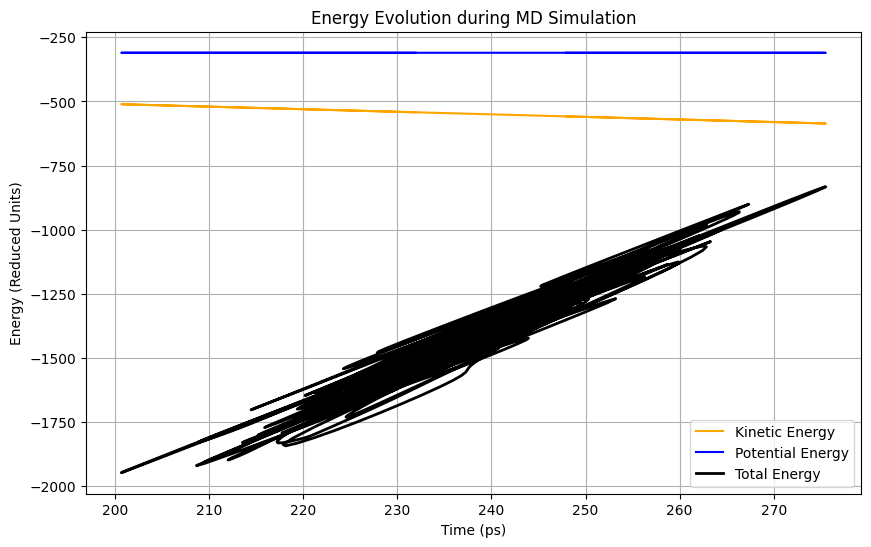

In [16]:
import matplotlib.pyplot as plt

# The simulation starts here
if __name__ == "__main__":
    times, kins, pots, totals = simulate()

    # --- Plotting Code ---
    plt.figure(figsize=(10, 6))
    
    plt.plot(times, kins, label='Kinetic Energy', color='orange')
    plt.plot(times, pots, label='Potential Energy', color='blue')
    plt.plot(times, totals, label='Total Energy', color='black', linewidth=2)
    
    plt.title('Energy Evolution during MD Simulation')
    plt.xlabel('Time (ps)')
    plt.ylabel('Energy (Reduced Units)')
    plt.legend()
    plt.grid(True)
    plt.show()